## Training Notebook
- This notebook is intended for the training and extraction of Model weights as a *.pth* file for the [**PCB Defect Detection**](https://github.com/akash-selvaraj/PCB-Defect-Detection).
- Run this in [**Google Colab**](https://colab.research.google.com/) with **Google Drive** Mounted for the *.pth* file to be saved in your *Drive*.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Download and unzip directly into the specified folder in your Google Drive
!curl -L "https://universe.roboflow.com/ds/4sc9I3Stz2?key=OZ8bHGoqy8" -o /content/drive/MyDrive/PCBDEF/roboflow.zip
!unzip /content/drive/MyDrive/PCBDEF/roboflow.zip -d /content/drive/MyDrive/PCBDEF
!rm /content/drive/MyDrive/PCBDEF/roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   914  100   914    0     0   3140      0 --:--:-- --:--:-- --:--:--  3151
100 74.7M  100 74.7M    0     0  22.9M      0  0:00:03  0:00:03 --:--:-- 29.7M
Archive:  /content/drive/MyDrive/PCBDEF/roboflow.zip
 extracting: /content/drive/MyDrive/PCBDEF/README.dataset.txt  
 extracting: /content/drive/MyDrive/PCBDEF/README.roboflow.txt  
   creating: /content/drive/MyDrive/PCBDEF/test/
 extracting: /content/drive/MyDrive/PCBDEF/test/01_missing_hole_06_jpg.rf.3ec21699d8a5e5de0ebfc5f7dc041006.jpg  
 extracting: /content/drive/MyDrive/PCBDEF/test/01_missing_hole_06_jpg.rf.fbb2f84d18fbcb42b96199ac58b6f28a.jpg  
 extracting: /content/drive/MyDrive/PCBDEF/test/01_missing_hole_11_jpg.rf.3761982e10be78f5b58f338922f009ff.jpg  
 extracting: /content/drive/MyDrive/PCBDEF/test/01_missing_hole_18_jpg.rf.cc198f3dd59321b5e67c116c8dad55f1.jpg  
 

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-w7sjqliv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-w7sjqliv
  Resolved https://github.com/facebookresearch/detectron2.git to commit 18f69583391e5040043ca4f4bebd2c60f0ebfde0
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.6 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6052956 sha256=a905a27bf2f772bcb9580b8cf559a8a5b4300148bdca9c3abe87fe50ee387604
  Stored in directory: /tmp/pip-ephem-wheel-cache-pbgl5nsf/wheels/17/d9/40/60db98e485aa9455

In [3]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
import os

In [ ]:
# Register COCO-style datasets
train_dataset_path = "/content/drive/MyDrive/PCBDEF/train/_annotations.coco.json"
val_dataset_path = "/content/drive/MyDrive/PCBDEF/valid/_annotations.coco.json"
train_images_path = "/content/drive/MyDrive/PCBDEF/train"
val_images_path = "/content/drive/MyDrive/PCBDEF/valid"

# Register the train and val datasets
register_coco_instances("pcb_defects_train", {}, train_dataset_path, train_images_path)
register_coco_instances("pcb_defects_val", {}, val_dataset_path, val_images_path)

# Load the configuration
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/PCBDEF/yaml/ssd/SSD_X_101_32x8d_FPN_1x.yaml")
cfg.DATASETS.TRAIN = ("pcb_defects_train",)
cfg.DATASETS.TEST = ("pcb_defects_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = ""
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.OUTPUT_DIR = "/content/drive/MyDrive/PCBDEF/output_pcb_defects"

# Create output directory if it doesn't exist
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Custom Trainer
class PCBTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, False, output_dir=output_folder)

# Training
trainer = PCBTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Save the final trained model weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
print(f"Model weights saved at {cfg.MODEL.WEIGHTS}")


[07/15 05:54:10 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/15 05:54:45 d2.utils.events]:  eta: 3:52:39  iter: 19  total_loss: 3.646  loss_cls: 2.001  loss_box_reg: 0.0001602  loss_mask: 0.6931  loss_rpn_cls: 0.6922  loss_rpn_loc: 0.2572    time: 1.4234  last_time: 1.3844  data_time: 0.1171  last_data_time: 0.0042   lr: 4.9953e-06  max_mem: 3918M
[07/15 05:55:18 d2.utils.events]:  eta: 3:51:19  iter: 39  total_loss: 3.553  loss_cls: 1.962  loss_box_reg: 0.000172  loss_mask: 0.6933  loss_rpn_cls: 0.6922  loss_rpn_loc: 0.214    time: 1.3781  last_time: 1.5270  data_time: 0.0051  last_data_time: 0.0112   lr: 9.9902e-06  max_mem: 3919M
[07/15 05:55:46 d2.utils.events]:  eta: 3:50:09  iter: 59  total_loss: 3.515  loss_cls: 1.876  loss_box_reg: 0.0001802  loss_mask: 0.6929  loss_rpn_cls: 0.692  loss_rpn_loc: 0.2339    time: 1.3726  last_time: 1.4156  data_time: 0.0250  last_data_time: 0.0045   lr: 1.4985e-05  max_mem: 3919M
[07/15 05:56:14 d2.utils.events]:  eta: 3:50:24  iter: 79  total_loss: 3.494  loss_cls: 1.759  loss_box_reg: 0.0001341  loss

backbone.bottom_up.res2.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up.res3.0.conv1.norm.{bias, running_mean, running_var, weight}
backbone.bottom_up.res3.0.conv1.weight
backbone.bottom_up.res3.0.conv2.norm.{bias, running_mean,

{'instances': Instances(num_instances=0, image_height=640, image_width=640, fields=[pred_boxes: Boxes(tensor([], size=(0, 4))), scores: tensor([]), pred_classes: tensor([], dtype=torch.int64)])}


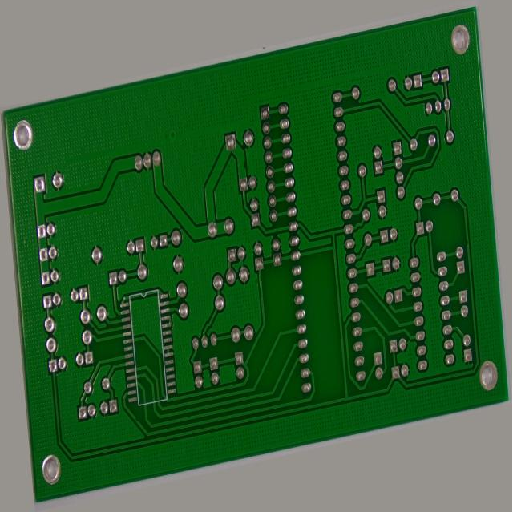

In [4]:
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

# Load the configuration
cfg = get_cfg()
cfg.merge_from_file("/content/drive/MyDrive/PCBDEF/yaml/rcnn/faster_rcnn_R_50_SSD_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/PCBDEF/output_pcb_defects/model_final.pth"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.MODEL.DEVICE = "cpu"  # Set to "cuda" if you have a GPU
# Create a predictor
pcb_metadata = MetadataCatalog.get("pcb_defects_train")

# Create a predictor
predictor = DefaultPredictor(cfg)

# Load the image for inference
image_path = "/content/drive/MyDrive/PCBDEF/test/01_mouse_bite_07_jpg.rf.539e23716fcc945b1815a4dca667405b.jpg"  # Replace with your image path
im = cv2.imread(image_path)
outputs = predictor(im)
print(outputs)
# Set a confidence threshold for predictions
confidence_threshold = 0.5  # Adjust as needed
instances = outputs["instances"]

# Normalize the scores between 0 and 1
if len(instances.scores) > 0:
    max_score = instances.scores.max()
    normalized_scores = instances.scores / max_score if max_score > 0 else instances.scores

    # Filter instances based on the normalized scores
    filtered_instances = instances[normalized_scores > confidence_threshold]
else:
    filtered_instances = instances  # No filtering if no scores are found

# Visualize predictions with original colors
v = Visualizer(im[:, :, ::-1],
               metadata=pcb_metadata,
               scale=0.8,
               instance_mode=ColorMode.IMAGE)  # Keeps the original color
v = v.draw_instance_predictions(filtered_instances.to("cpu"))

# Display the image
cv2_imshow(v.get_image()[:, :, ::-1])


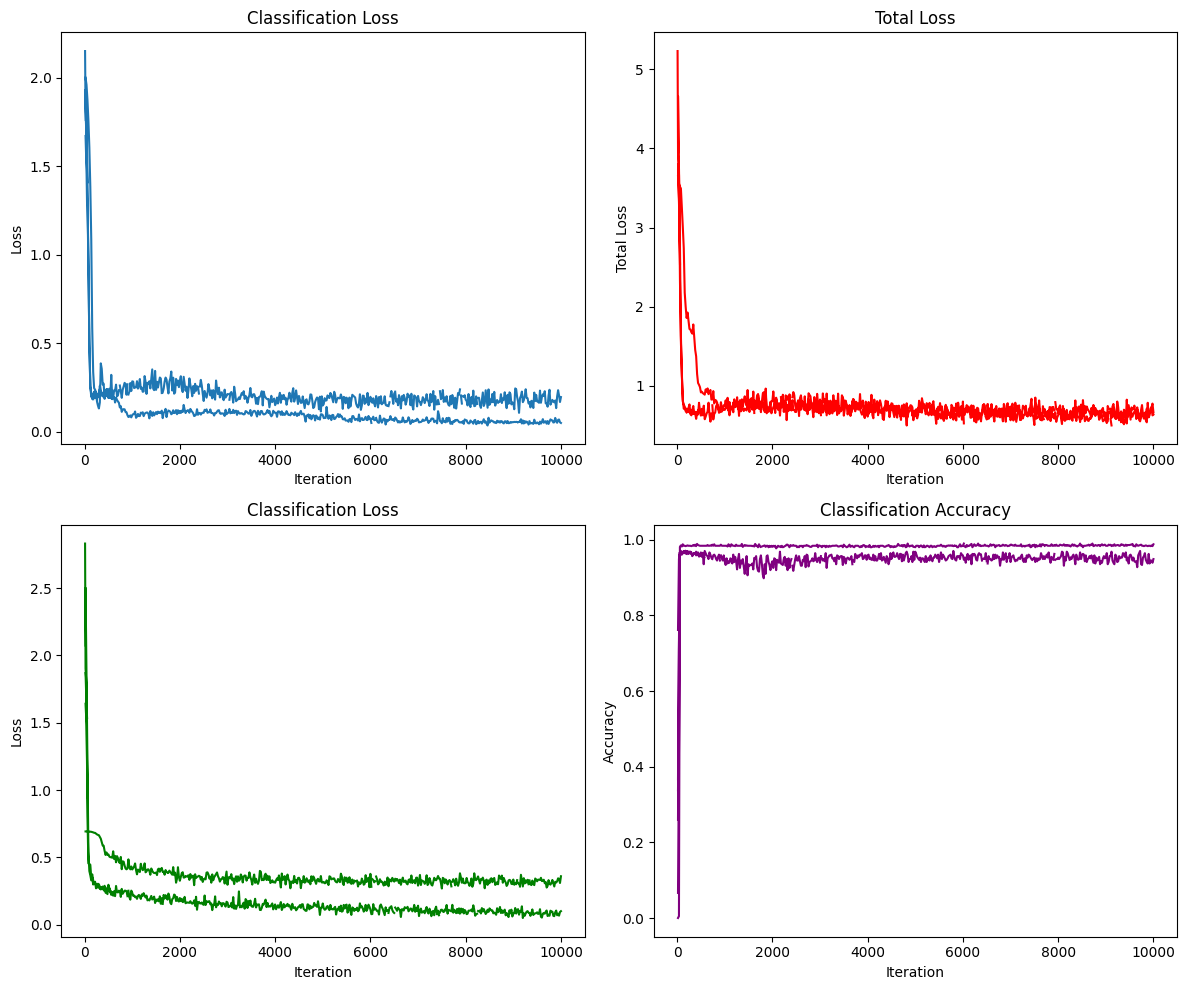

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Function to read JSON file line-by-line and parse each line
def read_json_file(file_path):
    data = []
    try:
        with open(file_path, 'r') as file:
            for line in file:
                # Each line is a JSON object, so load it individually
                data.append(json.loads(line))
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None

# Path to JSON file
json_file_path = "/content/drive/MyDrive/PCBDEF/output_pcb_defects/metrics.json"
data = read_json_file(json_file_path)

# Convert list of JSON objects to DataFrame
df = pd.DataFrame(data)

# Plotting the data
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot Classification Loss
axs[0, 0].plot(df['iteration'], df['loss_cls'], label='Classification Loss')
axs[0, 0].set_title('Classification Loss')
axs[0, 0].set_xlabel('Iteration')
axs[0, 0].set_ylabel('Loss')

# Plot Total Loss
axs[0, 1].plot(df['iteration'], df['total_loss'], label='Total Loss', color='red')
axs[0, 1].set_title('Total Loss')
axs[0, 1].set_xlabel('Iteration')
axs[0, 1].set_ylabel('Total Loss')

# Plot Classification Loss
axs[1, 0].plot(df['iteration'], df['loss_rpn_cls'], label='Classification Loss', color='green')
axs[1, 0].set_title('Classification Loss')
axs[1, 0].set_xlabel('Iteration')
axs[1, 0].set_ylabel('Loss')

# Plot Classification Accuracy
axs[1, 1].plot(df['iteration'], df['fast_rcnn/cls_accuracy'], label='Classification Accuracy', color='purple')
axs[1, 1].set_title('Classification Accuracy')
axs[1, 1].set_xlabel('Iteration')
axs[1, 1].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()
